# Chunking and Chinking

Chunk --> is process of grouping the word into phrase that have more meaning .

Chink -->  is process of excluding the certain word from the chunk.
For example, in the sentence "I like to play soccer on the weekends with my friends from college," we might want to identify the chunk "play soccer on the weekends with my friends from college," but exclude the phrase "I like to" at the beginning.


## Chunk pattern 

1. These are modified version of regular expression.
2. Chunk pattern is try to match the part of speech tags.

In [1]:
from nltk.chunk.regexp import tag_pattern2re_pattern
tag_pattern2re_pattern("<DT>?<NN.*>+")

#? these function used by the RegexParser.

'(<(DT)>)?(<(NN[^\\{\\}<>]*)>)+'

## RegexParser

In [2]:
from nltk.chunk import RegexpParser
import nltk
chunker = RegexpParser(
    r"""
    NP : 
        {<DT><.*>*<NN.*>}  # chunk is surrounded by the curly braces
        }<VB.*>{                # chink is specified using the flip curly braces
    """
)

#? This regex says that there are two rule for parsing the Noun Phrase.
#? 1. {<DT><.*>*<NN.*>} ---> starting with determiner and end with the noun ,
#? 2. }<VB.*>{   --> chink (exclude) the verb from the chunk 

In [3]:
tag_pattern2re_pattern("<VB.*>")

'(<(VB[^\\{\\}<>]*)>)'

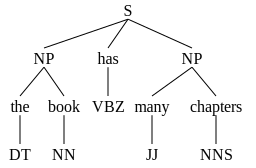

In [4]:
sent = "the book has many chapters"
chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))

## How it works.

1.  The sentence is converted into Tree.
2.  This Tree is used to create the ChunkString.
3.  RegexpParser parse the grammar and create the RegexpChunkParser(NP)
4.  Then the ChunkRule is created and applied to the ChunkString,which match the entire string.
5.  Then the StripRule is created and applied to the ChunkString,which exclude the verb from the chunk , which break the entire NP into NP - VBZ - NP.
6.  Then the ChunkString is converted into Tree.

In [38]:
from nltk.chunk.regexp import ChunkRule,ChunkString,StripRule
from nltk.tree import Tree

In [39]:
tag_sent = nltk.pos_tag(nltk.word_tokenize(sent))
tag_sent

[('the', 'DT'),
 ('book', 'NN'),
 ('has', 'VBZ'),
 ('many', 'JJ'),
 ('chapters', 'NNS')]

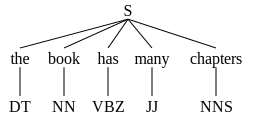

In [40]:
t = Tree('S',tag_sent)
t

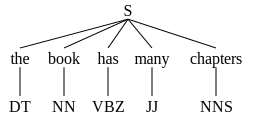

In [41]:
chunk_string = ChunkString(t)
chunk_string.to_chunkstruct()

In [42]:
rule1 = ChunkRule("<DT><NN.*><.*>*<NN.*>","Noun phrase start with determiner and end with noun.")
rule1.apply(chunk_string)

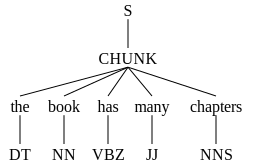

In [43]:
chunk_string.to_chunkstruct()

In [44]:
rule2 = StripRule("<VB.*>","chink the Verb")
rule2.apply(chunk_string)

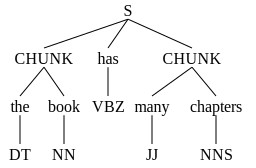

In [45]:
chunk_string.to_chunkstruct()
#? Chunk is tree not as NP

## RegexChunkParser

RegexpParser internally create the "RegexpChunkParser" for the each chunk. so that it can store the label of the label.

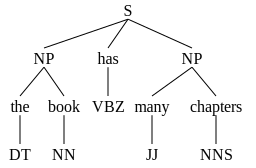

In [46]:
from nltk.chunk import RegexpChunkParser
chunker = RegexpChunkParser(rules=[rule1,rule2],
                            chunk_label="NP")
chunker.parse(t)

## Alternative Patterns

In [47]:
chunker = RegexpParser(
    r"""
    NP : 
        {<DT><NN.*>}
        {<JJ><NN.*>}
    """
)
#? this pattern produce the same result as above

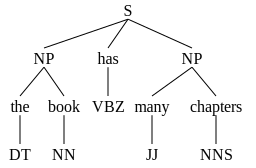

In [49]:
chunker.parse(t)

## ChunkRule with context

We Chunk the word based on the surrounding tags.

For Example if we want to chunk the only "book" that is followed by the determiner.

In [51]:
from nltk.chunk.regexp import ChunkRuleWithContext

chunk_with_ctx = ChunkRuleWithContext(
    left_context_tag_pattern="<DT>",
    chunk_tag_pattern="<NN.*>",
    right_context_tag_pattern="<.*>",
    descr="chunk the noun only after the determiner"
)

In [54]:
chunk_string = ChunkString(t)
chunk_string

<ChunkString: '<DT><NN><VBZ><JJ><NNS>'>

In [57]:
chunk_with_ctx.apply(chunkstr=chunk_string)

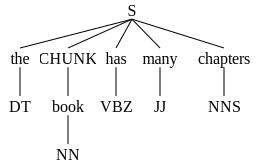

In [59]:
chunk_string.to_chunkstruct()

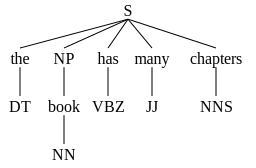

In [60]:
# the above chunk with context can be implemented in the RegexpParser
chunker = RegexpParser(
    r"""
    NP : <DT>{<NN.*>} # chunk the noun which is followed by "Det"
    """
)
chunker.parse(t)

# Merging and Splitting

1. Merge ---> merger the two chunk based on the end of first chunk and beginning of the second chunk.
   1. Rule for merge `<DT> {} <NN>`
2. Spilt ---> split the single chunk based on the split rule.
   1. Rule for spilt `<DT> }{ <NN>`

In [63]:
sent = "the sushi roll was filled with the fish"
sent_tag = nltk.pos_tag(nltk.word_tokenize(sent))
sent_tag

[('the', 'DT'),
 ('sushi', 'NN'),
 ('roll', 'NN'),
 ('was', 'VBD'),
 ('filled', 'VBN'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('fish', 'NN')]

Exercise :

1. The whole sentence is chunked.
2. The chunk is split into multiple chunk "after every noun".
3. Each chunk with a determiner is split into separate chunks.
4. Chunks ending with a noun are merged with the next chunk if it begins with a noun

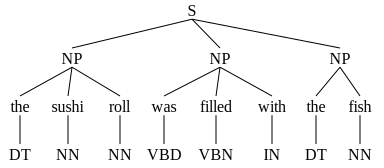

In [64]:
chunker = nltk.RegexpParser(
    r"""
    NP : 
        {<.*>*}             # the whole sentence is chunked
        <NN.*>}{<.*>        # chunk is split after every noun
        <.*>}{<DT>          # chunk with determiner is split
        <NN.*>{}<NN.*>      # merger the two chunk when one end with noun and other start with noun.
    """
)
chunker.parse(sent_tag)

## How it works

In [65]:
from nltk.chunk.regexp import ChunkRule,MergeRule,SplitRule,ChunkString
from nltk.tree import Tree

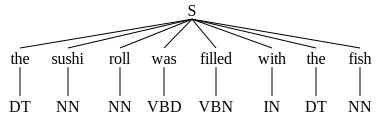

In [67]:
chunk_string = ChunkString(Tree("S",sent_tag))
chunk_string.to_chunkstruct()

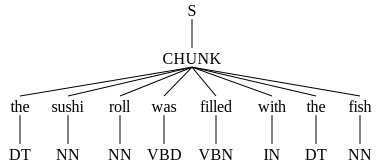

In [68]:
rule1 = ChunkRule("<.*>*","Whole sentence as chunk")
rule1.apply(chunk_string)
chunk_string.to_chunkstruct()

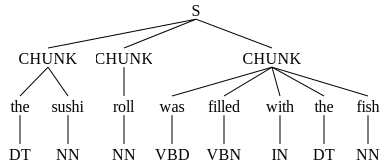

In [70]:
rule2 = SplitRule(
    left_tag_pattern="<NN.*>",
    right_tag_pattern="<.*>",
    descr="Spilt after the every noun"
)
rule2.apply(chunk_string)
chunk_string.to_chunkstruct()

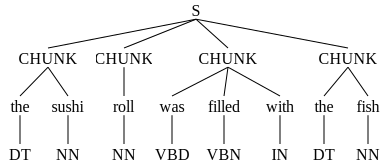

In [71]:
rule3 = SplitRule(
    left_tag_pattern="<.*>",
    right_tag_pattern="<DT>",
    descr="slipt the chunk when there is det"
)
rule3.apply(chunk_string)
chunk_string.to_chunkstruct()

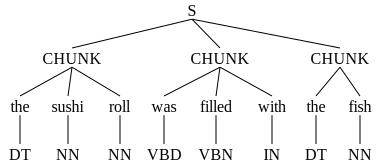

In [72]:
rule4 =MergeRule(
    left_tag_pattern="<NN.*>",
    right_tag_pattern="<NN.*>",
    descr="Merge two chuck when end with noun and start with noun"
)
rule4.apply(chunk_string)
chunk_string.to_chunkstruct()

## RegexpChunkRule from string

In [73]:
from nltk.chunk.regexp import RegexpChunkRule

In [74]:
RegexpChunkRule.fromstring("{<DT><.*>*<NN.*>}")
#? this will create the chunk rule

<ChunkRule: '<DT><.*>*<NN.*>'>

In [76]:
RegexpChunkRule.fromstring("}<VB.*>{")
#? this will create the strip rule

<StripRule: '<VB.*>'>

In [77]:
RegexpChunkRule.fromstring("<.*>}{<DT>")
#? spilt rule

<SplitRule: '<.*>', '<DT>'>

In [79]:
RegexpChunkRule.fromstring("<NN.*>{}<NN.*>")
#? Merger rule

<MergeRule: '<NN.*>', '<NN.*>'>

## Chunk Rule Parser

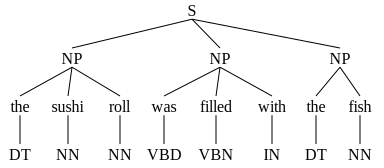

In [80]:
chunker = RegexpChunkParser(
    rules=[rule1,rule2,rule3,rule4],
    chunk_label="NP"
)
chunker.parse(sent_tag)

# Expanding and Removing the Chunk

1. RegexpChunkRule has 7 subclass
    1. ChunkRule
    2. StripRule
    3. MergeRule
    4. SpiltRule
    5. ExpandLeftRule
    6. ExpandRightRule
    7. UnChunkRule
2. Out of 7 subclass 4 can be used in RegexpParser
    1. ChunkRule
    2. StripRule
    3. MergeRule
    4. SpiltRule
3. Remaining three cant used in the RegexpParer so we have create them separately.
4. `ExpandLeftRule:` Add the `chink` word in the left to the chunk
5. `ExpandRightRule:` Add the `chink` word in the right to the chunk
6. These are same as MergerRule but here we are merging the Chink and Chunk.
7. `UnChunkRule` : UnChunk any matching chunk. 


Exercise : 
1. Use the ExpandLeftChunk to join the `<DT> (Chink)` and `<NN> (chunk)` into single chunk.
2. Use the ExpandRightChunk to join the `<NN> (Chunk)` and `<NNS> (Chink)` into single chunk.
3. then unchunk the whole sentence.

In [81]:
from nltk.chunk.regexp import ExpandLeftRule,ExpandRightRule,UnChunkRule

In [83]:
chunk_noun = ChunkRule("<NN>", "chunk the noun")
expand_left = ExpandLeftRule(
    left_tag_pattern="<DT>",
    right_tag_pattern="<NN>",
    descr="merge the chink and chunk"
)
expand_right = ExpandRightRule(
    left_tag_pattern="<NN>",
    right_tag_pattern="<NNS>",
    descr="merge the chunk and chink"
)
un_chunk = UnChunkRule("<.*>*","unchunk the whole chunk")

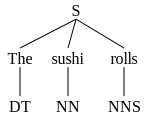

In [88]:
sent = "The sushi rolls"
sent_tag = nltk.pos_tag(nltk.word_tokenize(sent))
tree = Tree("S",sent_tag)
chunk_string = ChunkString(tree)
chunk_string.to_chunkstruct()

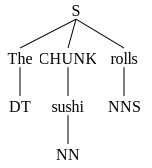

In [89]:
chunk_noun.apply(chunk_string)
chunk_string.to_chunkstruct()

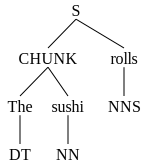

In [90]:
expand_left.apply(chunk_string)
chunk_string.to_chunkstruct()

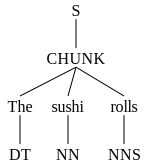

In [91]:
expand_right.apply(chunk_string)
chunk_string.to_chunkstruct()

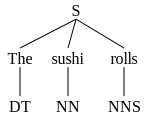

In [92]:
un_chunk.apply(chunk_string)
chunk_string.to_chunkstruct()

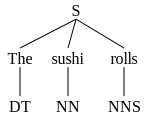

In [93]:
sent = "The sushi rolls"
sent_tag = nltk.pos_tag(nltk.word_tokenize(sent))
tree = Tree("S",sent_tag)
chunk_string = ChunkString(tree)
chunk_string.to_chunkstruct()

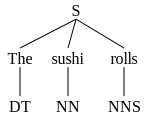

In [94]:
chunker = RegexpChunkParser([chunk_noun,expand_left,expand_right,un_chunk])
chunker.parse(tree)

# Partial Parsing
 We can have multiple phrase type and we can have a grammar.

In [103]:
from nltk.corpus import conll2000

In [141]:
chunker = RegexpParser(
    r"""
    NP : 
        {<DT>?<NN.*>+}      # chunk with optional determiner with nouns
        <JJ>{}<NN.*>        # merge adjective to the noun chunk
    PP :
        {<IN>}              # Preposition Chunk
    VP :
        {<MD>?<VB.*>}       # chunk with optional modal with verb
    """
)
#? comment will added as descr in Rule.

In [142]:
chunker._stages

[<RegexpChunkParser with 2 rules>,
 <RegexpChunkParser with 1 rules>,
 <RegexpChunkParser with 1 rules>]

In [143]:
chunker._stages[0].rules()[0]

<ChunkRule: '<DT>?<NN.*>+'>

In [144]:
chunker._stages[0].rules()[0].descr()

'chunk with optional determiner with nouns'

In [145]:
score = chunker.accuracy(conll2000.chunked_sents()) # this return the ChunkScore object
score.accuracy()

0.6148573545757688

In [146]:
type(score)

nltk.chunk.util.ChunkScore

## ChunkScore Metrics



In [147]:
score.precision()

0.60201948127375

In [127]:
score.recall()

0.606072502505847

In [128]:
len(score.missed())

47161

In [129]:
len(score.incorrect())

47967

In [130]:
len(score.correct())

119720

In [131]:
len(score.guessed())

120526

In [134]:
120526 - 119720

806

In [135]:
47967 - 47161

806

In [ ]:
Re